## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

### Code

In [1]:
import glob

import numpy as np
import scipy as sp
import scipy.io
import scipy.signal
from matplotlib import pyplot as plt


def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls

def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]


def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))

def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)

def BandpassFilter(signal, pass_band):
    '''
    from fourier_transform_II exercise of Intro Digital sampling and Signal Processing
    receive a signal and return band pass filter of it
    
    # fs 125 Hz as per troika dataset readme
    '''
    b, a = scipy.signal.butter(5, pass_band, btype='bandpass', fs=125)
    return scipy.signal.filtfilt(b, a, signal)


def RunPulseRateAlgorithm(data_fl, ref_fl):
    # Load data using LoadTroikaDataFile
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
    
    #based on readme file BMP0 field has the ground truth
    reference_label = sp.io.loadmat(ref_fl)['BPM0'].reshape(-1)

    #pulse rate restricted between 40BPM (beats per minute) and 240BPM
    ppg_filtered = BandpassFilter(ppg, (40/60,240/60))
    
    accx_filtered = BandpassFilter(accx, (40/60,240/60))
    accy_filtered = BandpassFilter(accy, (40/60,240/60))
    accz_filtered = BandpassFilter(accz, (40/60,240/60))

    time_window = 8*125
    time_interval = 2*125 #2s time as per project requirement  X fs
    freq_list = []
    conf_list=[]
    for window in range(0, len(ppg_filtered)- time_window +1, time_interval):
        #print(f'{window} / {window+time_window}')
        #filter signals per window of 1000 points
        ppg_range= ppg_filtered[window:window+time_window]
        accx_range = accx_filtered[window:window+time_window]
        accy_range = accy_filtered[window:window+time_window]
        accz_range = accz_filtered[window:window+time_window]
        #calculate fft based on Fourier transform in practice lession 2, chapter 13
        ppg_ft = np.abs(np.fft.rfft(ppg_range))
        accx_ft = np.abs(np.fft.rfft(accx_range))
        accy_ft = np.abs(np.fft.rfft(accy_range))
        accz_ft = np.abs(np.fft.rfft(accz_range))
        #calculate its frequencies
        ppg_freq = np.fft.rfftfreq(len(ppg_range),1/125)
        #accx_freq = np.fft.rfftfreq(len(accx_range),1/125)
        #accy_freq = np.fft.rfftfreq(len(accy_range),1/125)
        #accz_freq = np.fft.rfftfreq(len(accz_range),1/125)
        
        #filter freq between 40BPM (beats per minute) and 240BPM
        ppg_ft = ppg_ft[(ppg_freq >= (40/60)) & (ppg_freq <= (240/60))]
        ppg_freq = ppg_freq[(ppg_freq >= (40/60)) & (ppg_freq <= (240/60))]
        


        ppg_peaks= scipy.signal.find_peaks(ppg_ft)[0]
        accx_peaks= scipy.signal.find_peaks(accx_ft)[0]
        accy_peaks= scipy.signal.find_peaks(accy_ft)[0]
        accz_peaks= scipy.signal.find_peaks(accz_ft)[0]

        #find highest peak that is not in the accelerometer
        peak =ppg_peaks[-1]
        for pk in range(len(ppg_peaks)-1,0,-1):
            if(ppg_peaks[pk] not in accx_peaks):
                if(ppg_peaks[pk] not in accy_peaks):
                    if(ppg_peaks[pk] not in accz_peaks):
                        peak=ppg_peaks[pk]
                        break

        #get frequency from that peak
        freq = ppg_freq[list(ppg_peaks).index(peak)]
        #freq*60 for BPM
        freq_list.append(freq*60)
        nearby_freq = (ppg_freq >= freq - 10/60) & (ppg_freq <= freq + 10/60)
        spec_sum = np.sum(ppg_ft)
        conf_list.append(np.sum(ppg_ft[nearby_freq])/spec_sum)
        #plt.figure(figsize=(12, 8))
        #plt.plot(peak,ppg_ft,'r.')
        #plt.show()


    # Compute pulse rate estimates and estimation confidence.

    # Return per-estimate mean absolute error and confidence as a 2-tuple of numpy arrays.
    errors, confidence = np.abs(np.subtract(np.array(freq_list),reference_label)), np.array(conf_list)  # Dummy placeholders. Remove
    return errors, confidence

In [2]:
Evaluate()

48.610939262454266

In [3]:
data_fls,ref_fls = LoadTroikaDataset()

In [4]:
data_fls#signal data

['./datasets/troika/training_data\\DATA_01_TYPE01.mat',
 './datasets/troika/training_data\\DATA_02_TYPE02.mat',
 './datasets/troika/training_data\\DATA_03_TYPE02.mat',
 './datasets/troika/training_data\\DATA_04_TYPE01.mat',
 './datasets/troika/training_data\\DATA_04_TYPE02.mat',
 './datasets/troika/training_data\\DATA_05_TYPE02.mat',
 './datasets/troika/training_data\\DATA_06_TYPE02.mat',
 './datasets/troika/training_data\\DATA_07_TYPE02.mat',
 './datasets/troika/training_data\\DATA_08_TYPE02.mat',
 './datasets/troika/training_data\\DATA_10_TYPE02.mat',
 './datasets/troika/training_data\\DATA_11_TYPE02.mat',
 './datasets/troika/training_data\\DATA_12_TYPE02.mat']

In [5]:
ref_fls#reference data

['./datasets/troika/training_data\\REF_01_TYPE01.mat',
 './datasets/troika/training_data\\REF_02_TYPE02.mat',
 './datasets/troika/training_data\\REF_03_TYPE02.mat',
 './datasets/troika/training_data\\REF_04_TYPE01.mat',
 './datasets/troika/training_data\\REF_04_TYPE02.mat',
 './datasets/troika/training_data\\REF_05_TYPE02.mat',
 './datasets/troika/training_data\\REF_06_TYPE02.mat',
 './datasets/troika/training_data\\REF_07_TYPE02.mat',
 './datasets/troika/training_data\\REF_08_TYPE02.mat',
 './datasets/troika/training_data\\REF_10_TYPE02.mat',
 './datasets/troika/training_data\\REF_11_TYPE02.mat',
 './datasets/troika/training_data\\REF_12_TYPE02.mat']

In [6]:
ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

In [7]:
ppg

array([  4. ,   6. ,   3. , ...,  86. , 104. , 118.5])

In [8]:
accx

array([-0.0702, -0.0702, -0.0546, ...,  0.4134,  0.4134,  0.4134])

In [9]:
accy

array([ 0.3432,  0.3588,  0.3666, ..., -0.2808, -0.273 , -0.273 ])

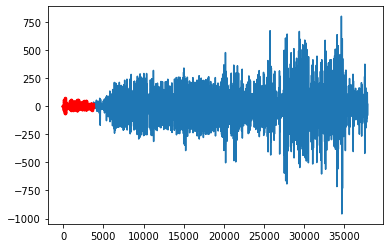

In [12]:
#PPG peaks - 2-ppg-peaks exercise from Intro to Sensors
ppg_filtered = BandpassFilter(ppg, (40/60,240/60))
ppg_ft = np.abs(np.fft.rfft(ppg_filtered))
pks= scipy.signal.find_peaks(ppg_ft)[0]
plt.plot(ppg_filtered)
plt.plot(pks,ppg_filtered[pks], 'r.', ms=5)

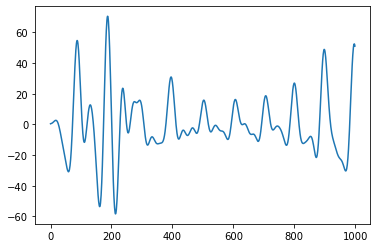

In [13]:
plt.plot(ppg_filtered[0:1000])

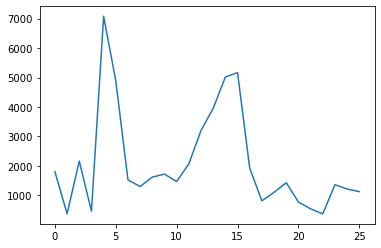

In [15]:


signal=ppg_filtered[0:1000]
n_samples = len(signal)  # No zero padding
freqs = np.fft.rfftfreq(n_samples, 1/125)
fft = np.abs(np.fft.rfft(signal))



plt.plot(fft[(freqs>40/60) & (freqs<240/60)])



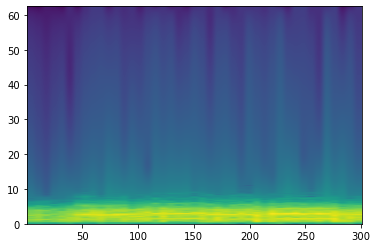

In [19]:
filt_ppg_specs, filt_ppg_freqs,_,filt_ppg_im = plt.specgram(ppg_filtered, NFFT = (8*125), Fs=125)
plt.show()

-----
### Project Write-up

Answer the following prompts to demonstrate understanding of the algorithm you wrote for this specific context.

> - **Code Description** - Include details so someone unfamiliar with your project will know how to run your code and use your algorithm. 
> - **Data Description** - Describe the dataset that was used to train and test the algorithm. Include its short-comings and what data would be required to build a more complete dataset.
> - **Algorithhm Description** will include the following:
>   - how the algorithm works
>   - the specific aspects of the physiology that it takes advantage of
>   - a describtion of the algorithm outputs
>   - caveats on algorithm outputs 
>   - common failure modes
> - **Algorithm Performance** - Detail how performance was computed (eg. using cross-validation or train-test split) and what metrics were optimized for. Include error metrics that would be relevant to users of your algorithm. Caveat your performance numbers by acknowledging how generalizable they may or may not be on different datasets.

Your write-up goes here...

-----
### Next Steps
You will now go to **Test Your Algorithm** (back in the Project Classroom) to apply a unit test to confirm that your algorithm met the success criteria. 